python -m venv store_forcast
pip install --upgrade cython
pip install pystan==2.17.1 #2.19.1.1
pip install statsmodels==0.12.2
pip install kats

https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_201_forecasting.ipynb
https://www.kaggle.com/code/luisblanche/look-what-the-kats-dragged-in



https://www.kaggle.com/code/loicge/sales-top-down-approach-with-prophet-0-52#6.-Top-down-approach-with-Prophet

# Sales - Top down approach with Prophet

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime, timedelta
from tqdm import tqdm
from pathlib import Path
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import os
DIR = Path('./data/')

In [77]:
holidays = pd.read_csv(DIR / 'holidays_events.csv')
holidays["date"] = pd.to_datetime(holidays.date)

train = pd.read_csv(DIR / 'preprocessed'/ 'train_preprocessed.csv')
validation = pd.read_csv(DIR / 'preprocessed'/ 'validation_preprocessed.csv')

train["date"] = pd.to_datetime(train.date)
validation["date"] = pd.to_datetime(validation.date)

train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")

validation.onpromotion = validation.onpromotion.astype("float16")
validation.sales = validation.sales.astype("float32")

validation.set_index('date', inplace=True)
train.set_index('date', inplace=True)

In [5]:
train.tail()

,sales,onpromotion
date,,
2017-07-26,7.406531e+05,18720.0
2017-07-27,6.598498e+05,8000.0
2017-07-28,8.350997e+05,13848.0
2017-07-29,1.032311e+06,9096.0
2017-07-30,1.123752e+06,10224.0


In [6]:
validation.tail()

,sales,onpromotion
date,,
2017-08-11,826373.7500,14176.0
2017-08-12,792630.5625,8312.0
2017-08-13,865639.6875,9280.0
2017-08-14,760922.3750,8044.0
2017-08-15,762661.9375,10608.0


In [78]:
train_df, validate_df = train, validation

train_df.reset_index(inplace= True)
train_df.columns = ['ds','y','on_promotion']

validate_df.reset_index(inplace= True)
validate_df.columns = ['ds','y','on_promotion']

In [79]:
validate_df.shape

(16, 3)

In [80]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=validate_df.shape[0]+1)
forecast = m.predict(future)
validate_df_m1 =pd.merge(validate_df, forecast, left_on='ds', right_on='ds',how='left')

21:32:49 - cmdstanpy - INFO - Chain [1] start processing
21:32:50 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
data_all = pd.concat([train_df,validate_df_m1], sort=False)
data_all.set_index('ds', inplace=True)

In [14]:
data_all

,y,on_promotion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,
2013-01-01,2511.618896,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,496092.406250,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,361461.218750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,354459.687500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,477350.125000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.750000,14176.0,890523.272315,625235.091431,8.978542e+05,890523.272315,890523.272315,-126384.341847,-126384.341847,-126384.341847,-57467.255063,-57467.255063,-57467.255063,-68917.086784,-68917.086784,-68917.086784,0.0,0.0,0.0,7.641389e+05
2017-08-12,792630.562500,8312.0,890762.355759,810160.757173,1.099981e+06,890762.355759,890762.355759,66066.226992,66066.226992,66066.226992,134799.673043,134799.673043,134799.673043,-68733.446051,-68733.446051,-68733.446051,0.0,0.0,0.0,9.568286e+05
2017-08-13,865639.687500,9280.0,891001.439203,870541.740692,1.151280e+06,891001.439203,891001.439203,121009.981811,121009.981811,121009.981811,188939.389687,188939.389687,188939.389687,-67929.407876,-67929.407876,-67929.407876,0.0,0.0,0.0,1.012011e+06


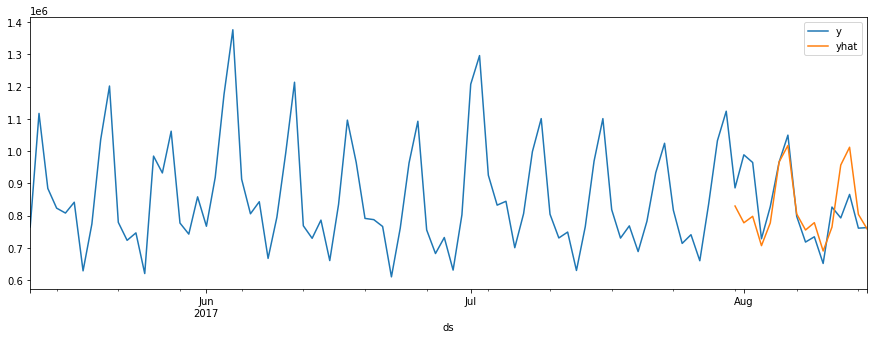

In [32]:
_ = data_all[['y','yhat']].tail(16*6).plot(figsize=(15, 5))

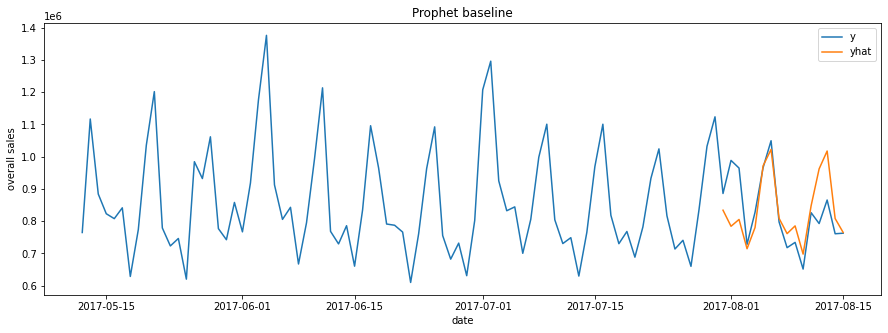

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(data_all[['y','yhat']].tail(16*6))

plt.ylabel("overall sales")
plt.xlabel("date")
plt.title("Prophet baseline")

plt.legend(labels=['y', 'yhat'])
plt.savefig("./figs/prophet_baseline.png",bbox_inches="tight")

In [38]:
validate_df_m1

,ds,y,on_promotion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-31,8.858568e+05,8648.0,887893.354433,692666.305442,9.853072e+05,887893.354433,887893.354433,-58270.721167,-58270.721167,...,-21048.246676,-21048.246676,-21048.246676,-37222.474491,-37222.474491,-37222.474491,0.0,0.0,0.0,8.296226e+05
1,2017-08-01,9.885278e+05,10152.0,888132.437877,635692.276544,9.138116e+05,888132.437877,888132.437877,-110532.072567,-110532.072567,...,-68833.125247,-68833.125247,-68833.125247,-41698.947320,-41698.947320,-41698.947320,0.0,0.0,0.0,7.776004e+05
2,2017-08-02,9.647120e+05,16528.0,888371.521321,652803.028285,9.289395e+05,888371.521321,888371.521321,-90724.227191,-90724.227191,...,-44662.794379,-44662.794379,-44662.794379,-46061.432812,-46061.432812,-46061.432812,0.0,0.0,0.0,7.976473e+05
3,2017-08-03,7.280685e+05,7860.0,888610.604765,563787.841442,8.481523e+05,888610.604765,888610.604765,-181961.600673,-181961.600673,...,-131727.641365,-131727.641365,-131727.641365,-50233.959308,-50233.959308,-50233.959308,0.0,0.0,0.0,7.066490e+05
4,2017-08-04,8.277757e+05,14192.0,888849.688208,643842.449327,9.221005e+05,888849.688208,888849.688208,-111609.385935,-111609.385935,...,-57467.255063,-57467.255063,-57467.255063,-54142.130872,-54142.130872,-54142.130872,0.0,0.0,0.0,7.772403e+05
5,2017-08-05,9.656936e+05,8688.0,889088.771652,823920.389179,1.103879e+06,889088.771652,889088.771652,77084.874761,77084.874761,...,134799.673043,134799.673043,134799.673043,-57714.798282,-57714.798282,-57714.798282,0.0,0.0,0.0,9.661736e+05
6,2017-08-06,1.049559e+06,9568.0,889327.855096,872272.028704,1.154217e+06,889327.855096,889327.855096,128053.703185,128053.703185,...,188939.389687,188939.389687,188939.389687,-60885.686501,-60885.686501,-60885.686501,0.0,0.0,0.0,1.017382e+06
7,2017-08-07,7.974649e+05,8208.0,889566.938540,664059.409527,9.344889e+05,889566.938540,889566.938540,-84643.182411,-84643.182411,...,-21048.246676,-21048.246676,-21048.246676,-63594.935735,-63594.935735,-63594.935735,0.0,0.0,0.0,8.049238e+05
8,2017-08-08,7.177664e+05,10640.0,889806.021984,604171.052893,9.021890e+05,889806.021984,889806.021984,-134623.639923,-134623.639923,...,-68833.125247,-68833.125247,-68833.125247,-65790.514676,-65790.514676,-65790.514676,0.0,0.0,0.0,7.551824e+05
9,2017-08-09,7.341397e+05,16120.0,890045.105427,644287.698995,9.203381e+05,890045.105427,890045.105427,-112092.261652,-112092.261652,...,-44662.794379,-44662.794379,-44662.794379,-67429.467273,-67429.467273,-67429.467273,0.0,0.0,0.0,7.779528e+05


In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error ,mean_squared_log_error

# Get the Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))


In [82]:
print(mean_squared_error(validate_df_m1.y, validate_df_m1.yhat))
print(mean_absolute_error(validate_df_m1.y, validate_df_m1.yhat))
print(rmsle(validate_df_m1.y, validate_df_m1.yhat))
  

8661926728.53342
67894.58912758196
0.10672917726787304


In [42]:
# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]
holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)

# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 # Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


# Split
# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)
holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()

C:\Users\henninta\AppData\Local\Temp\ipykernel_28388\2256450892.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holidays = holidays.append(tr).reset_index(drop = True)
C:\Users\henninta\AppData\Local\Temp\ipykernel_28388\2256450892.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
C:\Users\henninta\AppData\Local\Temp\ipykernel_28388\2256450892.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')


In [43]:
national

,date,holiday_national
14,2012-08-10,Primer Grito de Independencia
19,2012-11-02,Dia de Difuntos
20,2012-11-03,Independencia de Cuenca
29,2012-12-21,Navidad
31,2012-12-22,Navidad
...,...,...
329,2016-05-27,Batalla de Pichincha
331,2016-08-12,Primer Grito de Independencia
332,2017-01-02,Primer dia del ano
334,2017-05-26,Batalla de Pichincha


In [44]:
# use national and events because they apply for the whole contry
train_df_max =max(train_df.ds)
train_df_min =min(train_df.ds)

validate_df_max =max(validate_df.ds)
validate_df_min =min(validate_df.ds)

print(train_df_max)
print(train_df_min)
print(validate_df_max)
print(validate_df_min)

2017-07-30 00:00:00
2013-01-01 00:00:00
2017-08-15 00:00:00
2017-07-31 00:00:00


In [45]:
train_national = []
validate_national = []

for i in national.date:
    if i >= train_df_min and i <= validate_df_max:
        train_national.append(i)
    if i >= validate_df_min and i <= validate_df_max:
        validate_national.append(i)

train_events = []
validate_events = []

for i in events.date:
    if i >= train_df_min and i <= train_df_max:
        train_events.append(i)
    if i >= validate_df_min and i <= validate_df_max:
        validate_events.append(i)


In [46]:
# Python
national = pd.DataFrame({
  'holiday': 'national',
  'ds': national.date,
})
events = pd.DataFrame({
  'holiday': 'events',
  'ds': events.date,
})
holidays = pd.concat((national, events))

19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing


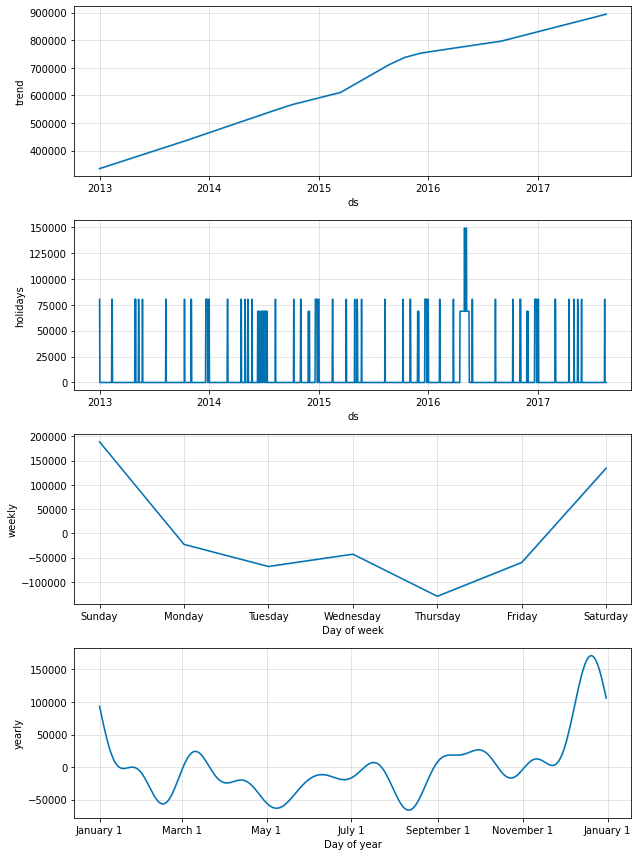

In [66]:



m = Prophet(holidays = holidays)
m.fit(train_df)
future = m.make_future_dataframe(periods=validate_df.shape[0]+1)
forecast = m.predict(future)

validate_df_m2 =pd.merge(validate_df, forecast, left_on='ds', right_on='ds',how='left')

fig = m.plot_components(forecast)
fig.savefig('./figs/prophet_components_plot.png')

In [67]:
validate_df_m2

,ds,y,on_promotion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-31,8.858568e+05,8648.0,890207.740868,692259.507656,9.704910e+05,890207.740868,890207.740868,-56187.261965,-56187.261965,...,-22676.762334,-22676.762334,-22676.762334,-33510.499631,-33510.499631,-33510.499631,0.0,0.0,0.0,8.340205e+05
1,2017-08-01,9.885278e+05,10152.0,890487.711390,647917.526845,9.216808e+05,890487.711390,890487.711390,-106321.047949,-106321.047949,...,-68179.614749,-68179.614749,-68179.614749,-38141.433200,-38141.433200,-38141.433200,0.0,0.0,0.0,7.841667e+05
2,2017-08-02,9.647120e+05,16528.0,890767.681911,668292.907205,9.421583e+05,890767.681911,890767.681911,-85452.007816,-85452.007816,...,-42799.068653,-42799.068653,-42799.068653,-42652.939163,-42652.939163,-42652.939163,0.0,0.0,0.0,8.053157e+05
3,2017-08-03,7.280685e+05,7860.0,891047.652433,574401.120170,8.553590e+05,891047.652433,891047.652433,-176556.173581,-176556.173581,...,-129591.845973,-129591.845973,-129591.845973,-46964.327609,-46964.327609,-46964.327609,0.0,0.0,0.0,7.144915e+05
4,2017-08-04,8.277757e+05,14192.0,891327.622954,634082.642980,9.110837e+05,891327.622954,891327.622954,-110888.060573,-110888.060573,...,-59891.073729,-59891.073729,-59891.073729,-50996.986844,-50996.986844,-50996.986844,0.0,0.0,0.0,7.804396e+05
5,2017-08-05,9.656936e+05,8688.0,891607.593476,837224.831553,1.097818e+06,891607.593476,891607.593476,79797.449971,79797.449971,...,134473.570975,134473.570975,134473.570975,-54676.121004,-54676.121004,-54676.121004,0.0,0.0,0.0,9.714050e+05
6,2017-08-06,1.049559e+06,9568.0,891887.563997,895640.575152,1.165797e+06,891887.563997,891887.563997,130732.369304,130732.369304,...,188664.794463,188664.794463,188664.794463,-57932.425159,-57932.425159,-57932.425159,0.0,0.0,0.0,1.022620e+06
7,2017-08-07,7.974649e+05,8208.0,892167.534519,675175.932903,9.488034e+05,892167.534519,892167.534519,-83380.417120,-83380.417120,...,-22676.762334,-22676.762334,-22676.762334,-60703.654785,-60703.654785,-60703.654785,0.0,0.0,0.0,8.087871e+05
8,2017-08-08,7.177664e+05,10640.0,892447.505040,616953.402219,8.938093e+05,892447.505040,892447.505040,-131115.663317,-131115.663317,...,-68179.614749,-68179.614749,-68179.614749,-62936.048569,-62936.048569,-62936.048569,0.0,0.0,0.0,7.613318e+05
9,2017-08-09,7.341397e+05,16120.0,892727.475562,658348.162538,9.236527e+05,892727.475562,892727.475562,-107384.635413,-107384.635413,...,-42799.068653,-42799.068653,-42799.068653,-64585.566759,-64585.566759,-64585.566759,0.0,0.0,0.0,7.853428e+05


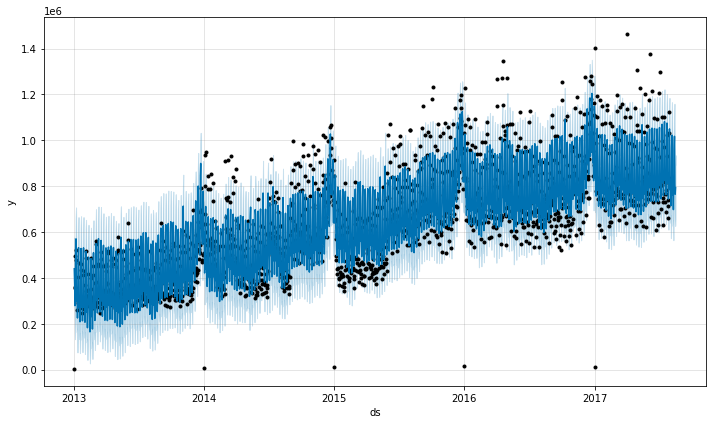

In [49]:
fig1 = m.plot(forecast)

In [50]:
forecast[['ds', 'yhat']]

,ds,yhat
0,2013-01-01,4.400742e+05
1,2013-01-02,3.752837e+05
2,2013-01-03,2.788178e+05
3,2013-01-04,3.391240e+05
4,2013-01-05,5.245060e+05
...,...,...
1680,2017-08-12,9.622790e+05
1681,2017-08-13,1.017648e+06
1682,2017-08-14,8.081142e+05
1683,2017-08-15,7.650235e+05


In [68]:
data_all = pd.concat([train_df,validate_df_m2], sort=False)
data_all.set_index('ds', inplace=True)

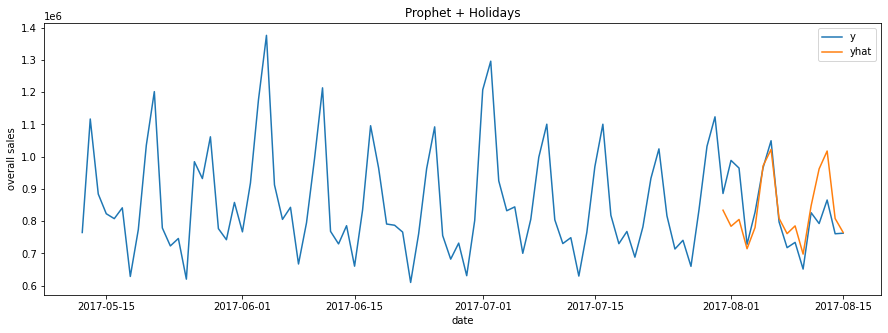

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(data_all[['y','yhat']].tail(16*6))

plt.ylabel("overall sales")
plt.xlabel("date")
plt.title("Prophet + Holidays")

plt.legend(labels=['y', 'yhat'])
plt.savefig("./figs/prophet_holidays.png",bbox_inches="tight")

In [53]:
print(mean_squared_error(validate_df_m2.y, validate_df_m2.yhat))
print(mean_absolute_error(validate_df_m2.y, validate_df_m2.yhat))
print(rmsle(validate_df_m2.y, validate_df_m2.yhat))

#0.2775965314301966


8401204411.780855
65890.04175649738
0.10471472504386517


In [55]:
train

,ds,y,on_promotion
0,2013-01-01,2.511619e+03,0.0
1,2013-01-02,4.960924e+05,0.0
2,2013-01-03,3.614612e+05,0.0
3,2013-01-04,3.544597e+05,0.0
4,2013-01-05,4.773501e+05,0.0
...,...,...,...
1663,2017-07-26,7.406531e+05,18720.0
1664,2017-07-27,6.598498e+05,8000.0
1665,2017-07-28,8.350997e+05,13848.0
1666,2017-07-29,1.032311e+06,9096.0


In [56]:
train_df

,ds,y,on_promotion
0,2013-01-01,2.511619e+03,0.0
1,2013-01-02,4.960924e+05,0.0
2,2013-01-03,3.614612e+05,0.0
3,2013-01-04,3.544597e+05,0.0
4,2013-01-05,4.773501e+05,0.0
...,...,...,...
1663,2017-07-26,7.406531e+05,18720.0
1664,2017-07-27,6.598498e+05,8000.0
1665,2017-07-28,8.350997e+05,13848.0
1666,2017-07-29,1.032311e+06,9096.0


In [70]:
def get_on_promotion(ds):
    return train[train.index == ds].on_promotion.item()


#train_df.iloc[1345:1347 ,0].apply(get_on_promotion)

In [59]:
train_df

,ds,y,on_promotion
0,2013-01-01,2.511619e+03,0.0
1,2013-01-02,4.960924e+05,0.0
2,2013-01-03,3.614612e+05,0.0
3,2013-01-04,3.544597e+05,0.0
4,2013-01-05,4.773501e+05,0.0
...,...,...,...
1663,2017-07-26,7.406531e+05,18720.0
1664,2017-07-27,6.598498e+05,8000.0
1665,2017-07-28,8.350997e+05,13848.0
1666,2017-07-29,1.032311e+06,9096.0


19:00:56 - cmdstanpy - INFO - Chain [1] start processing
19:00:57 - cmdstanpy - INFO - Chain [1] done processing


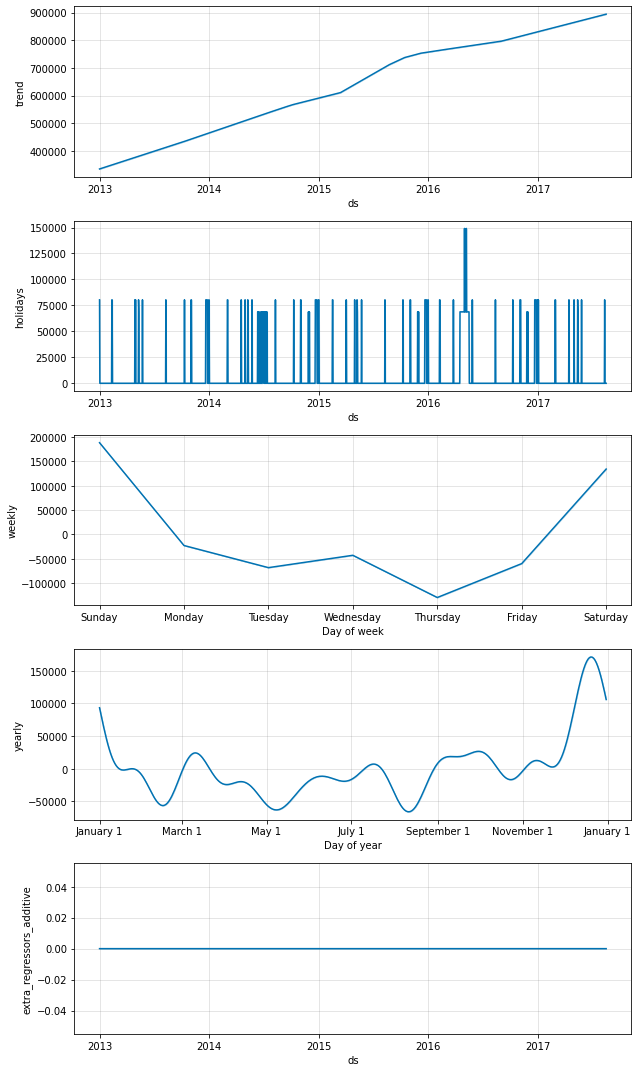

In [60]:
def get_on_promotion(ds):
    try:
        on_promo_value = train[train.index == ds].onpromotion.tolist()[0]
        if on_promo_value == None:
            on_promo_value = 0
        return on_promo_value
    except:
        return 0



train_df['on_promotion'] = train_df['ds'].apply(get_on_promotion)

m = Prophet(holidays = holidays)
m.add_regressor('on_promotion')
m.fit(train_df)
future = m.make_future_dataframe(periods=validate_df.shape[0]+1)
future['on_promotion'] = future['ds'].apply(get_on_promotion)

forecast = m.predict(future)

validate_df_m3 =pd.merge(validate_df, forecast, left_on='ds', right_on='ds',how='left')

fig = m.plot_components(forecast)

In [61]:
data_all = pd.concat([train_df,validate_df_m3], sort=False)
data_all.set_index('ds', inplace=True)

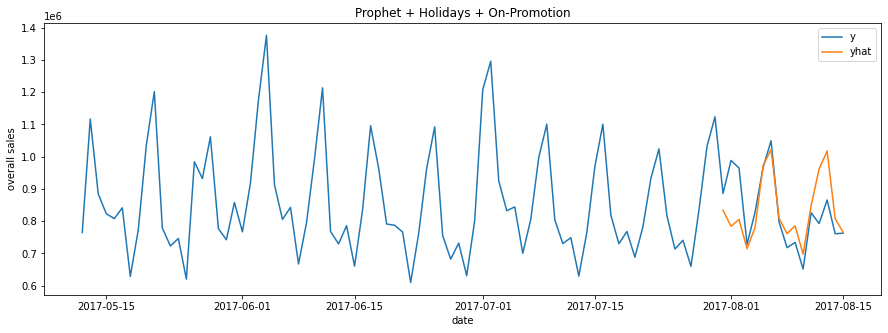

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(data_all[['y','yhat']].tail(16*6))

plt.ylabel("overall sales")
plt.xlabel("date")
plt.title("Prophet + Holidays + On-Promotion")

plt.legend(labels=['y', 'yhat'])
plt.savefig("./figs/prophet_holdays_on_promotion.png",bbox_inches="tight")

In [75]:
print(mean_squared_error(validate_df_m3.y, validate_df_m3.yhat))
print(mean_absolute_error(validate_df_m3.y, validate_df_m3.yhat))
print(rmsle(validate_df_m3.y, validate_df_m3.yhat))

print(format(mean_squared_error(validate_df_m3.y, validate_df_m3.yhat), 'e'))
#0.2775965314301966
#0.2775962821209458


8401204411.780855
65890.04175649738
0.10471472504386517
8.401204e+09


In [57]:
# df = train_df
# df = pd.merge(df, forecast_per_store, on=['ds', 'store_nbr'], how='left')
# df = df.assign(prop_family_per_store= df.y/df.y_store_nbr).fillna(0)

# group_by_store_df = df.groupby(['ds'] + ['store_nbr']).agg({'y': 'sum'}).reset_index()
# stores = list(set(group_by_store_df.store_nbr))
# n_cols = 6
# n_rows = int(len(stores)/n_cols)

# fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 40))

# k = 0
# for i in range(n_rows):
#     for j in range(n_cols):
#         sub_df = df[df.store_nbr == stores[k]]
#         sub_df = sub_df[sub_df.ds >= '2017-05-01']
#         for f in df.family.unique():
#             ts = sub_df[sub_df.family == f]
#             ax[i][j].plot(ts.ds, ts.prop_family_per_store)
#             ax[i][j].set_title("Store_nbr: " + str(stores[k]), size=16)
#         k += 1

The proportions are quite stable over time, therefore we'll use the last week of available data to calculate proportions over that week and repeat that weekly pattern to forecast the future proportions. It's a big assumption but acceptable for what we are trying to do.

In [58]:
# def get_last_available_week(df):
#     # Get date of the last available week
#     df = df.assign(diff_from_max_train_ds=df.ds - datetime.strptime(ds_range[1], "%Y-%m-%d"))
#     df = df.assign(nb_weeks=np.ceil(df.diff_from_max_train_ds.dt.days/7).astype('int'))
#     df = df.assign(last_week_ds=df.ds - (df.nb_weeks*7).map(lambda x: timedelta(x)))
    
#     return df

# def get_yhat(df):
#     df = pd.merge(df, 
#     df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns={'prop_family_per_store': 'last_week_prop_family_per_store'}),
#          left_on = ['last_week_ds', 'store_nbr', 'family'],
#          right_on=['ds', 'store_nbr', 'family'],
#          how='left'
#         ).drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis=1).rename(columns={'ds_x': 'ds'})

#     df = df.assign(yhat=df.yhat_store_nbr * df.last_week_prop_family_per_store)
    
#     return df

# df = get_last_available_week(df)
# df.head(2)

In [59]:
# df = get_yhat(df)
# df.head(2)

In [60]:
#print('RMSLE: %s' %rmsle(df[(df.ds > ds_range[1])].yhat, df[(df.ds > ds_range[1])].y))
